# Problem 2 - Unit Commitment

In [1]:
import numpy as np
import cvxpy as cp
import timeit

import matplotlib.pyplot as plt

# Definition of data

In [2]:
generation_costs = np.array([15, 20, 15, 20, 30, 25.])
startup_costs = np.array([75, 100, 75, 100, 100, 125.])
shutdown_costs = np.array([7.5, 10.0, 7.5, 10.0, 10.0, 12.5])
running_costs = np.array([10, 5, 10, 10, 10, 10.])

capacity = np.array([10, 5, 10, 10, 20, 30.])
ramp_up_rate = np.array([2, 5, 2, 5, 10, 5.])
ramp_down_rate = np.array([2, 5, 2, 5, 10, 5.])

initial_state = np.array([1, 0, 0, 0, 0, 0])

In [3]:
rt = np.array([15.2, 16.4, 16.1, 10.9, 14.8, 7.6, 15.6, 5.5, 9.2, 5.7, 1.5, 12.4, 10.4, 4.8, 14.3, 0.5, 6.6, 5.7, 11.5, 11.9, 2.8, 7.3, 6.7, 9.7])
dt = np.array([21.3, 21.4, 17.8, 20.9, 15.5, 17.6, 20.2, 23.8, 27.7, 30.1, 35.4, 39.4, 43.2, 47.0, 49.3, 51.5, 52.6, 50.3, 47.0, 43.1, 38.8, 33.2, 28.6, 24.3])

# Question 2.2

In [4]:
Tup = 3
Tdown = 2

In [9]:
# YOUR CODE HERE
# Hint: Define decision variables in CVXPY using
# shape = (2,2) # example: 2x2 binary matrix
# binary_example_variable = cp.Variable(shape, boolean=True)
# We recommend GLPK_MI solver
Ng = 6  # number of traditional generators
T = 24  # planning horizon
# Define variables
u = cp.Variable((Ng, T), boolean=True)  # generator is starting (flag)
v = cp.Variable((Ng, T), boolean=True)  # generator is shutting down (flag)
x = cp.Variable((Ng, T), boolean=True)  # generator is running (flag)
gt = cp.Variable((Ng, T))  # production of each traditional generator
# Construct the problem
objective = cp.Minimize(cp.sum(startup_costs @ u + shutdown_costs @ v 
                             + running_costs @ x + generation_costs @ gt))
constraints = [dt == cp.sum(gt, axis=0) + rt,
               0 <= gt, gt <= cp.multiply(np.tile(capacity, (T, 1)).T, x),
               x[:, :-1] - x[:, 1:] + u[:, 1:] >= 0,
               x[:, 1:] - x[:, :-1] + v[:, 1:] >= 0,
               *[x[:, t] - x[:, t-1] <= x[:, tau] 
                    for t in range(1, T) for tau in range(t+1, min(t + Tup, T))],
               *[x[:, t-1] - x[:, t] <= 1 - x[:, tau] 
                    for t in range(1, T) for tau in range(t+1, min(t + Tdown, T))],
               u[:, 0] == 0, x[:, 0] == initial_state, v[:, 0] == 0]
problem = cp.Problem(objective, constraints)

In [10]:
# Solve with GLPK.
problem.solve(solver=cp.GLPK_MI, verbose=0)
print(f"optimal value with GLPK_MI: {problem.value}", np.sum(gt.value, axis=1), 'running', x.value, sep='\n')
timeit.timeit() 

Long-step dual simplex will be used
optimal value with GLPK_MI: 11024.5
[202.7  61.4 166.8 100.7   0.   45.3]
running
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]]


0.008301086723804474

In [11]:
cost_per_gen=[]
for i in range(Ng):
    for t in range(T):
        cost_per_gen.append(startup_costs[i] * u.value[i][t] + shutdown_costs[i] * v.value[i][t] + running_costs[i] * x.value[i][t] + generation_costs[i] * gt.value[i][t])
    print(sum(cost_per_gen))
    cost_per_gen=[]

3280.5
1403.0
2747.0
2244.0
0.0
1349.9999999999998


In [12]:
opti_git_values = np.round_(gt.value, 1)

for i in range(0, len(opti_git_values)):
    print('Optimal g{}^t values:\n'.format(i+1), opti_git_values[i])

Optimal g1^t values:
 [ 6.1  5.   1.7 10.   0.7 10.   4.6 10.  10.  10.  10.  10.  10.  10.
 10.  10.  10.  10.  10.  10.  10.  10.  10.   4.6]
Optimal g2^t values:
 [-0.  -0.   0.  -0.  -0.  -0.  -0.  -0.  -0.   4.4  3.9  5.   5.   5.
  5.   5.   5.   5.   5.   1.2  5.   5.   1.9 -0. ]
Optimal g3^t values:
 [-0.  -0.   0.  -0.   0.   0.  -0.   8.3  8.5 10.  10.  10.  10.  10.
 10.  10.  10.  10.  10.  10.  10.  10.  10.  10. ]
Optimal g4^t values:
 [-0.  -0.   0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  10.   2.   7.8 10.
 10.  10.  10.  10.  10.  10.  10.   0.9 -0.  -0. ]
Optimal g5^t values:
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0.]
Optimal g6^t values:
 [-0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.   7.2
 -0.  16.  11.   9.6  0.5 -0.   1.  -0.  -0.  -0. ]


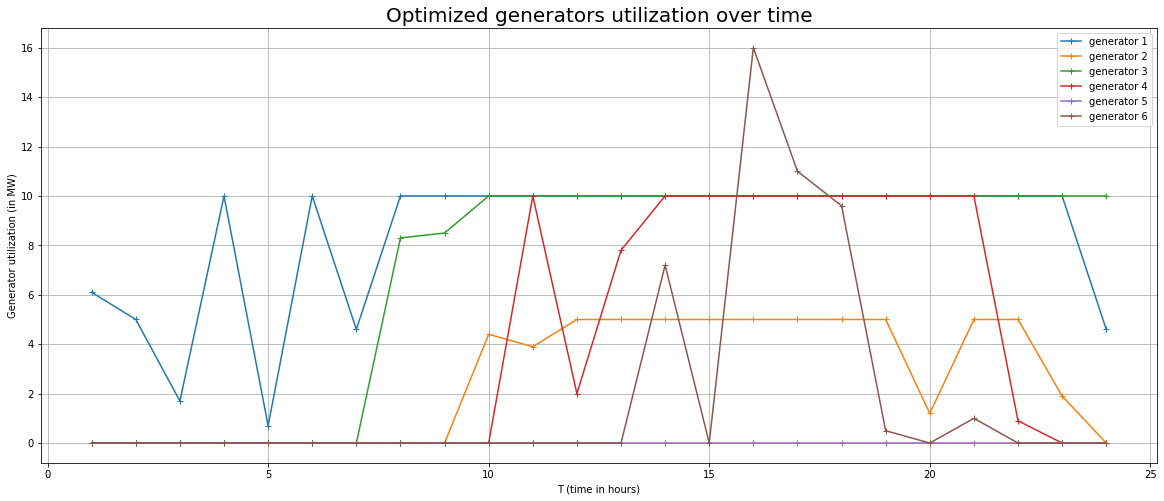

In [13]:
plt.figure(figsize=(20,8))

x_ticks = range(1, 25)

for i in range(0, len(gt.value)):
    plt.plot(x_ticks, gt.value[i], label='generator '+str(i+1), marker='+')

plt.ylabel('Generator utilization (in MW)')
plt.xlabel('T (time in hours)')
plt.title('Optimized generators utilization over time', fontsize=20)
plt.legend()
plt.grid()

plt.savefig('ex2.2.a.png')
plt.show()

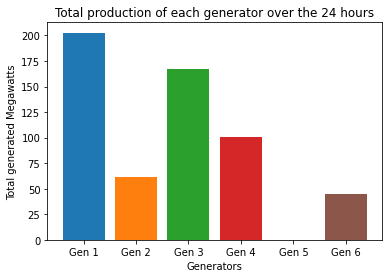

In [10]:
data = np.sum(gt.value, axis=1)

labels = ['Gen 1', 'Gen 2', 'Gen 3', 'Gen 4', 'Gen 5', 'Gen 6']
default_numpy_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(6,4))

plt.xticks(range(len(data)), labels)
plt.xlabel('Generators')
plt.ylabel('Total generated Megawatts')
plt.title('Total production of each generator over the 24 hours')
plt.bar(range(len(data)), data, color = default_numpy_colors[0:6])

plt.savefig('ex2.2.b.png')
plt.show()

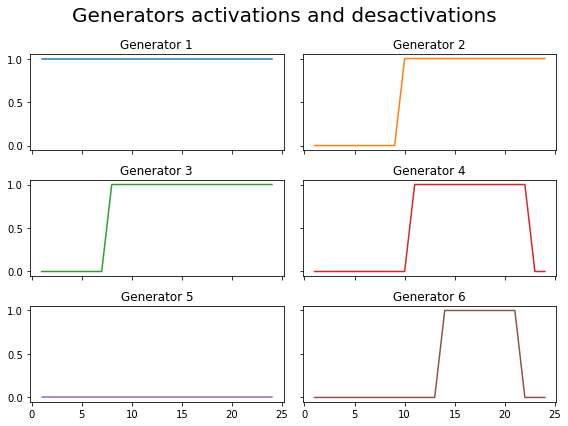

In [14]:
x_ticks = range(1, 25)

fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32)) = plt.subplots(3, 2, sharex = True, sharey = True,figsize=(8.0, 6.0))

ax11.plot(x_ticks, x.value[0], color='#1f77b4')
ax11.set_title('Generator 1')
ax12.plot(x_ticks, x.value[1], color='#ff7f0e')
ax12.set_title('Generator 2')
ax21.plot(x_ticks, x.value[2], color='#2ca02c')
ax21.set_title('Generator 3')
ax22.plot(x_ticks, x.value[3], color='#d62728')
ax22.set_title('Generator 4')
ax31.plot(x_ticks, x.value[4], color='#9467bd')
ax31.set_title('Generator 5')
ax32.plot(x_ticks, x.value[5], color='#8c564b')
ax32.set_title('Generator 6')

fig.suptitle('Generators activations and desactivations', fontsize=20)
plt.tight_layout()
plt.savefig('ex2.2.c.png')
plt.show()  

# Question 2.3 Relaxed

In [15]:
Tup = 3
Tdown = 2

In [16]:
# YOUR CODE HERE
# We recommend GLPK_MI solver
Ng = 6  # number of traditional generators
T = 24  # planning horizon
# Define variables
u = cp.Variable((Ng, T))  # generator is starting (flag)
v = cp.Variable((Ng, T))  # generator is shutting down (flag)
x = cp.Variable((Ng, T),boolean=True)  # generator is running (flag)
gt = cp.Variable((Ng, T))  # production of each traditional generator
# Construct the problem
objective = cp.Minimize(cp.sum(startup_costs @ u + shutdown_costs @ v + running_costs @ x 
                               + generation_costs @ gt))
constraints = [dt == cp.sum(gt, axis=0) + rt,
               0 <= gt, gt <= cp.multiply(np.tile(capacity, (T, 1)).T, x),
               x[:, :-1] - x[:, 1:] + u[:, 1:] >= 0,
               x[:, 1:] - x[:, :-1] + v[:, 1:] >= 0,
               *[x[:, t] - x[:, t-1] <= x[:, tau]
                 for t in range(1, T) for tau in range(t+1, min(t + Tup, T))],
               *[x[:, t-1] - x[:, t] <= 1 - x[:, tau]
                 for t in range(1, T) for tau in range(t+1, min(t + Tdown, T))],
               u[:, 0] == 0, x[:, 0] == initial_state, v[:, 0] == 0, 
               0 <= u, u <= 1, 0 <= v, v <= 1]
problem = cp.Problem(objective, constraints)

In [17]:
# Solve with GLPK.
problem.solve(solver=cp.GLPK_MI, verbose=0)
print(f"optimal value with GLPK_MI: {problem.value}", np.sum(
    gt.value, axis=1), 'running', x.value, sep='\n')
timeit.timeit() 

Long-step dual simplex will be used
optimal value with GLPK_MI: 11024.5
[199.5  54.2 170.  107.9   0.   45.3]
running
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]]


0.008580219000577927

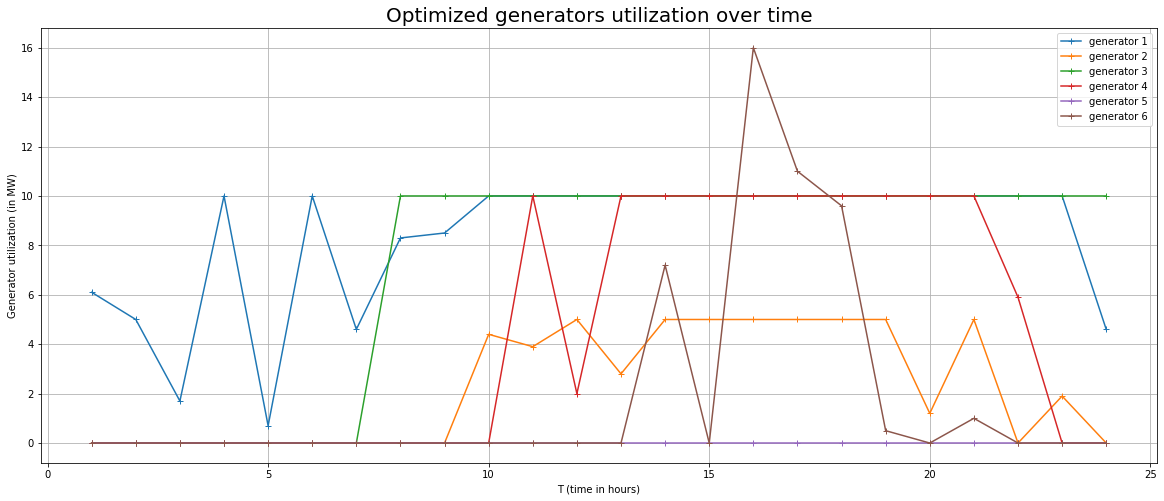

In [20]:
plt.figure(figsize=(20,8))

x_ticks = range(1, 25)

for i in range(0, len(gt.value)):
    plt.plot(x_ticks, gt.value[i], label='generator '+str(i+1), marker='+')

plt.ylabel('Generator utilization (in MW)')
plt.xlabel('T (time in hours)')
plt.title('Optimized generators utilization over time', fontsize=20)
plt.legend()
plt.grid()

plt.savefig('ex2.3.a.png')
plt.show()

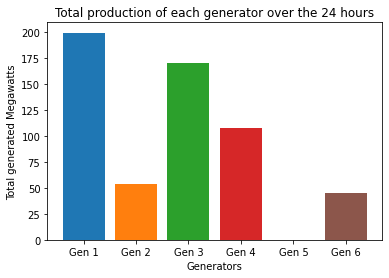

In [21]:
data = np.sum(gt.value, axis=1)

labels = ['Gen 1', 'Gen 2', 'Gen 3', 'Gen 4', 'Gen 5', 'Gen 6']
default_numpy_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(6,4))

plt.xticks(range(len(data)), labels)
plt.xlabel('Generators')
plt.ylabel('Total generated Megawatts')
plt.title('Total production of each generator over the 24 hours')
plt.bar(range(len(data)), data, color = default_numpy_colors[0:6])

plt.savefig('ex2.3.b.png')
plt.show()

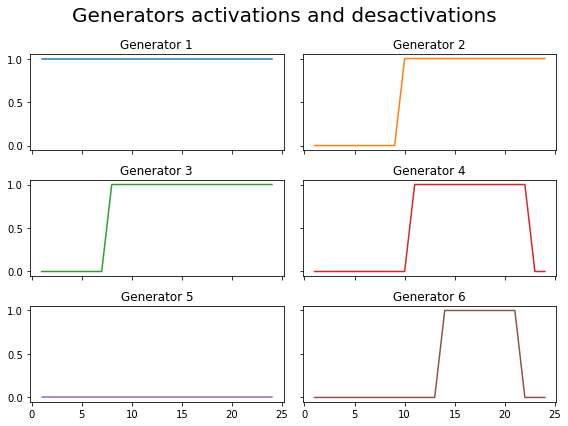

In [22]:
x_ticks = range(1, 25)

fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32)) = plt.subplots(3, 2, sharex = True, sharey = True,figsize=(8.0, 6.0))

ax11.plot(x_ticks, x.value[0], color='#1f77b4')
ax11.set_title('Generator 1')
ax12.plot(x_ticks, x.value[1], color='#ff7f0e')
ax12.set_title('Generator 2')
ax21.plot(x_ticks, x.value[2], color='#2ca02c')
ax21.set_title('Generator 3')
ax22.plot(x_ticks, x.value[3], color='#d62728')
ax22.set_title('Generator 4')
ax31.plot(x_ticks, x.value[4], color='#9467bd')
ax31.set_title('Generator 5')
ax32.plot(x_ticks, x.value[5], color='#8c564b')
ax32.set_title('Generator 6')

fig.suptitle('Generators activations and desactivations', fontsize=20)
plt.tight_layout()
plt.savefig('ex2.3.c.png')
plt.show()  